In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import XYZfromAET, AETfromXYZ

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 60. * DAY 
Tobs = 5 * DAY 
t_end = t_start + Tobs 
fsample = 0.1
delta_t = 1. / fsample
data_frequency = np.fft.rfftfreq(n=int(Tobs/delta_t), d=delta_t)[1:]
delta_f = data_frequency[1] - data_frequency[0]

In [3]:
# mask data at the null frequencies (around 0.25n Hz, n=1, 2, ...) since these are also the "zero" points of noise 
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 100):
    mask_idx = np.where(np.abs(data_frequency - 0.025 * i)<i*5e-4)[0] # 5e-4 is only an empirical choice 
    mask[mask_idx] = False  

# mask data lower than the sensitive band 
mask_idx = np.where(data_frequency<5e-5)[0]
mask[mask_idx] = False 

data_frequency = data_frequency[mask]
data_frequency.shape 

(20715,)

## Prepare models 

### orbit and noise 

In [4]:
# orbit model 
orbit = Orbit(OrbitDir='../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB')

# theoretical noise PSD model 
PSDfunc = TDIPSDs()

### waveform and response 
MBHB waveforms can be modeled with different complexities: 
- "primary" mode: only the (2,2) harmonic 
- "full" mode: including the (2,2), (2,1), (3,3), (3,2), (4,4), (4,3) harmonics at most 

In [5]:
mode = "primary" # "primary" or "full"
interp_waveform = True # True if the final TDI responses are interpolated from sparse frequency grid (recommanded when Nf > 1000), False if calculated at full frequency grid
use_gpu = True

if mode == "primary":
    modes = [(2,2)]
    approx = "IMRPhenomD"
elif mode == "full": 
    modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
    approx = "IMRPhenomHM"
else: 
    raise NotImplementedError("mode not implemented")

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

channel_names = ["A2", "E2", "T2"]

# response settings 
response_kwargs = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=interp_waveform,
)

## Waveform simulation

In [6]:
# set source parameters 
mbhb_parameters = {
    'chirp_mass': 1e6, # [Solar mass]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': t_end / DAY - 1., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

# waveform simulation 
wf_channels = FDTDI.Response(
    parameters=mbhb_parameters, 
    freqs=xp.array(data_frequency),  
    **response_kwargs, 
)

wf_channels.shape 

(3, 20715)

## Noise generation 
In principle, the statistical characteristics of noises after TDI combinations would vary with arm-lengths.     
However, given that the PSDs of the Michelson $A_2, E_2$ channels exhibit only moderate variations, the frequency-domain noise simulation based PSDs remains a reasonable simplification.   
On the contrary, we exclude $T_2$ channel in the subsequent analysis since its PSD is sensitive to arm-lengths, which greatly compromises the accuracy of frequency-domain noise simulation.    
Another simplification made in this example is that we assume that the noises of $A_2$, $E_2$, $T_2$ are independent, while in practice they are not. 

In [7]:
# use the median time to calculate armlengths
arm_time = (t_end + t_start) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency, arms), 
    PSDfunc.PSD_E2_unequal(data_frequency, arms), 
    PSDfunc.PSD_T2_unequal(data_frequency, arms)
])

Re_tmp = xp.random.normal(scale=xp.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = xp.random.normal(scale=xp.sqrt(PSD_channels / 4. / delta_f))
noise_channels = Re_tmp + 1.j * Im_tmp 

PSD_channels.shape, noise_channels.shape 

arm lengths: {'12': array(9.9423583), '13': array(9.99401934), '23': array(9.99148366), '21': array(9.94356135), '31': array(9.99487241), '32': array(9.99111644)}


((3, 20715), (3, 20715))

## Data combination 

In [8]:
data_channels = wf_channels + noise_channels 

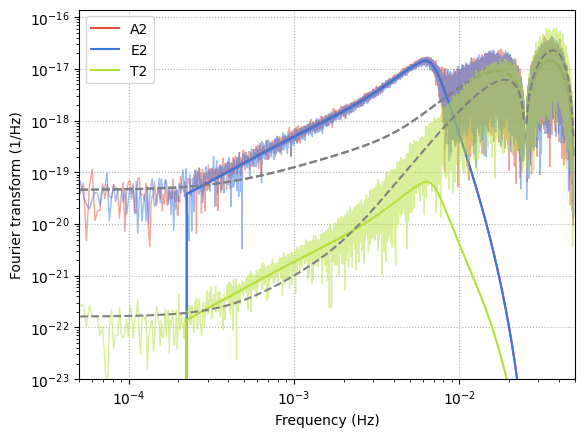

In [9]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency, xp.abs(wf_channels[ich]).get(), label=nch, color=SC_colors[str(ich+1)])
    plt.loglog(data_frequency, xp.abs(data_channels[ich]).get(), color=SC_colors[str(ich+1)], linewidth=1, alpha=0.5)
    plt.loglog(data_frequency, xp.sqrt(PSD_channels[ich] / 2. / delta_f).get(), color="grey", linestyle="--")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-23, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform (1/Hz)")
plt.grid(linestyle=":")

## Save to file 

In [10]:
datadict = {
    "frequency": data_frequency, 
    "AET": data_channels, 
    "parameters": mbhb_parameters, 
    "response_kwargs": response_kwargs, 
}

with open("FDSimulationData.pkl", "wb") as datafile: 
    pickle.dump(datadict, datafile)    

In [11]:
datadict

{'frequency': array([5.09259259e-05, 5.32407407e-05, 5.55555556e-05, ...,
        4.89953704e-02, 4.89976852e-02, 4.90000000e-02]),
 'AET': array([[ 1.30972768e-20-3.62572525e-20j, -6.92702068e-21-6.17933585e-20j,
          2.12278509e-21-4.25520420e-21j, ...,
         -8.87123719e-20-7.41604446e-20j,  4.62746014e-20+1.02501961e-20j,
         -6.22342224e-20-1.44888285e-19j],
        [ 2.21034010e-22+6.65531461e-20j,  6.07567038e-21+3.48150023e-20j,
         -2.11733338e-20+1.14197473e-20j, ...,
          2.46637448e-20+1.84757527e-19j,  7.00093331e-20-8.38338790e-20j,
         -1.17951442e-19+1.51978100e-19j],
        [-1.50118252e-22-2.09069418e-22j,  2.29513845e-22-1.63031057e-22j,
         -9.22951947e-23-4.31270427e-23j, ...,
         -4.23772461e-20+2.24753384e-19j,  9.85795272e-20-3.13209090e-19j,
          6.74861274e-20-1.45175399e-19j]]),
 'parameters': {'chirp_mass': 1000000.0,
  'mass_ratio': 0.4719138674211496,
  'spin_1z': -0.219017,
  'spin_2z': 0.777287,
  'coalescence_